Tutorial from [here](https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
stock_data = pd.read_csv("/home/jlangley/Downloads/HistoricalQuotes.csv")


In [32]:
stock_data.head(2)


,date,close,volume,open,high,low
0,16:00,"1,103.60","1,386,584","1,107.82","1,116.39","1,098.99"
1,2019/06/18,1103.6000,1386684.0000,1109.6900,1116.3900,1098.9900


In [34]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 6 columns):
date      1260 non-null object
close     1260 non-null object
volume    1260 non-null object
open      1260 non-null object
high      1260 non-null object
low       1260 non-null object
dtypes: object(6)
memory usage: 59.1+ KB


In [35]:
stock_data.high = (stock_data.high.str.split()).apply(lambda x: float(x[0].replace(',', '')))
stock_data.low = (stock_data.low.str.split()).apply(lambda x: float(x[0].replace(',', '')))

In [36]:
import math
stock_data["average"] = (stock_data["high"] + stock_data["low"])/2
stock_data.head(2)


,date,close,volume,open,high,low,average
0,16:00,"1,103.60","1,386,584","1,107.82",1116.39,1098.99,1107.69
1,2019/06/18,1103.6000,1386684.0000,1109.6900,1116.39,1098.99,1107.69


In [37]:
stock_data.volume = (stock_data.volume.str.split()).apply(lambda x: float(x[0].replace(',', '')))
input_feature= stock_data.iloc[:,[2,6]].values
input_data = input_feature

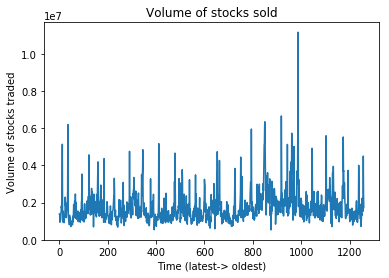

In [38]:
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

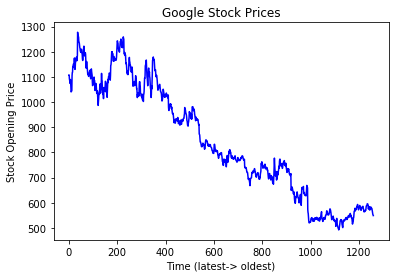

In [39]:
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [40]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])

In [41]:
lookback= 50

test_size=int(.3 * len(stock_data))
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [42]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(1209, 50, 2)
(428, 50, 2)


In [43]:
from keras import Sequential
from keras.layers import Dense, LSTM

ModuleNotFoundError: No module named 'keras'